# TME 4: Perceptron.

## HingeLoss

$ hinge(x) = max(0,-Y < \textbf{X,W}>) $

$ X \in \mathbb{R}^{nxm} $
$ Y \in \mathbb{R}^{nx1} $
$ W \in \mathbb{R}^{mx1} $

In [7]:
import arftools
import numpy as np
import matplotlib.pyplot as plt
import arftools

def gaussian_function(mu,sigma):
    K = 1/float(np.sqrt(2*np.pi))
    def func(x):
        return K*np.exp(-(np.dot((mu-x).T,(mu-x)))/float(2*sigma**2))
    return func

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def hinge_loss(X,Y,W):
    CW = -(Y*X.dot(W.T))
    Zeros = np.zeros(Y.shape)
    return np.maximum(Zeros,CW)
    
def hinge_loss_grad(X,Y,W):
    indicatrice = np.sign(hinge_loss(X,Y,W))
    NablaCW = indicatrice*-Y*X
    return NablaCW

def gaussian(x,mu,sigma):
    return (1/np.sqrt(2*np.pi*sigma))*np.exp(-(x-mu)**2)

class Perceptron(object):
    def __init__(self,loss,loss_g,max_iter=100,eps=0.1):
        self.max_iter, self.eps = max_iter,eps
        self.w = None
        self.loss = loss
        self.loss_g = loss_g
        self.kernel= None
        self.initialize_histo()
        
    def initialize_histo(self):
        self.w_histo = []
        self.loss_histo = []
        
    def initialize_w(self,D):
        self.w=np.random.random((1,D))
        
    def set_kernel(self,kernel):
        self.kernel=kernel
        
    def apply_kernel(self,datax,kernel='bias'):
        N = datax.shape[0] # Number of data points
        kernel_datax = datax.reshape(N,-1)
        if kernel=='bias':
            homogeneus = np.ones((N,1))
            kernel_datax = np.hstack((datax,homogeneus))
        if kernel=='polinomial2':
            homogeneus = np.ones((N,1))
            squared = datax**2
            kernel_datax = np.hstack((squared,datax,homogeneus))
        if kernel=='rbf':
            sigma = 1.0
            kernel_datax = np.zeros((N,N))
            for i in range(N):
                kernel_datax[i,:] = np.array(map(gaussian_function(datax[i,:],sigma),datax))
        return kernel_datax
    
    def fit_minibatch_and_test(self,datax,datay,testx,testy,batches=10,kernel=None):
        datay = datay.reshape(-1,1)
        # Number of data points
        N = datax.shape[0]
        datax = self.apply_kernel(datax,kernel=kernel)
        # dimension of data points
        D = datax.shape[1] 
        self.initialize_w(D)
        self.initialize_histo()
        batch_size = N/batches
        test_loss_histo = []
        for i in range(self.max_iter):
            self.w_histo += [self.w]
            # create batch
            batch_x = datax[(i%batches)*batch_size:((i%batches)+1)*batch_size]
            batch_y = datay[(i%batches)*batch_size:((i%batches)+1)*batch_size]
            # estimate loss in train
            CW = self.loss(batch_x,batch_y,self.w)
            loss = np.sum(CW)
            self.loss_histo += [loss]
            # estimate loss in test
            TCW = self.loss(testx,testy,self.w)
            test_loss = np.sum(TCW)
            test_loss_histo += [test_loss]
            # estimate gradient
            CW_grad = self.loss_g(batch_x,batch_y,self.w)
            collective_grad = np.sum(CW_grad,axis=0) # par ligne
            self.w -= collective_grad*self.eps
        return self.loss_histo, test_loss_histo
            
    def fit_minibatch(self,datax,datay,batches=10,kernel=None):
        datay = datay.reshape(-1,1)
        N = len(datay) # Number of data points
        datax = self.apply_kernel(datax,kernel=kernel)
        D = datax.shape[1] # dimension of data points
        self.initialize_w(D)
        self.initialize_histo()
        batch_size = N/batches
        for i in range(self.max_iter):
            self.w_histo += [self.w]
            batch_x = datax[(i%batches)*batch_size:((i%batches)+1)*batch_size]
            batch_y = datay[(i%batches)*batch_size:((i%batches)+1)*batch_size]
            CW = self.loss(batch_x,batch_y,self.w)
            loss = np.sum(CW)
            self.loss_histo += [loss]
            CW_grad = self.loss_g(batch_x,batch_y,self.w)
            collective_grad = np.sum(CW_grad,axis=0) # par ligne
            self.w -= collective_grad*self.eps
            
    def fit(self,datax,datay,kernel=None):
        if kernel == None:
            kernel = self.kernel
        self.fit_minibatch(datax,datay,batches=1,kernel=kernel)
            
    def predict(self,datax,kernel=None):
        if kernel == None:
            kernel = self.kernel
        datax = self.apply_kernel(datax,kernel=kernel)
        return np.sign(datax.dot(self.w.T))
    
    def decision_function(self,datax):
        return self.predict(datax)
    
    def predict_proba(self,datax,kernel=None):
        return sigmoid(self.predict(datax))
    
    def predict_proba_distance(self,datax,kernel=None):
        return self.predict(datax)
    
    def score(self,datax,datay):
        return np.mean(self.predict(datax).T[0]==datay)



start bias


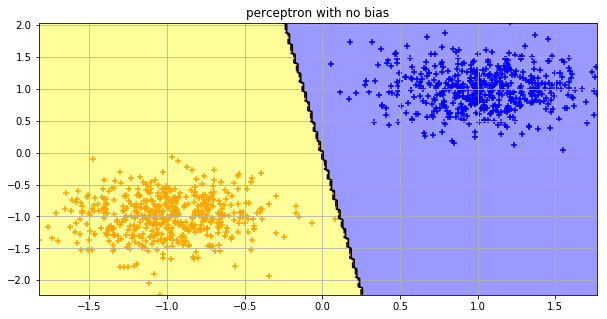

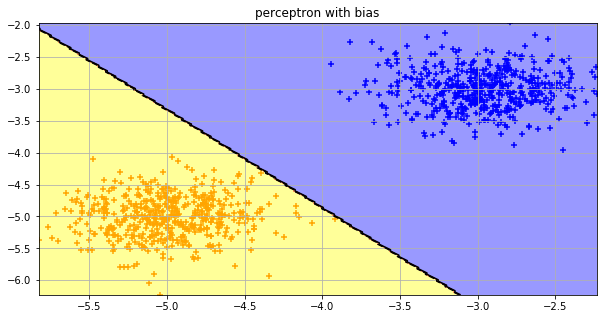

1.0


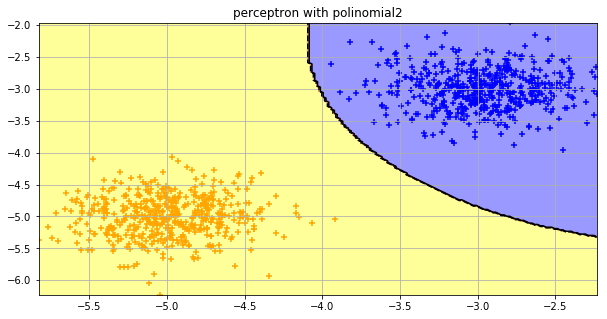

1.0


In [8]:

datax,datay = arftools.gen_arti()

figure = plt.figure(0,figsize=(10,5))

my_perceptron = Perceptron(hinge_loss,hinge_loss_grad)
my_perceptron.fit(datax,datay)
arftools.fig_plot_frontiere(plt,datax,my_perceptron.predict)
arftools.fig_plot_data(plt,datax,datay)
plt.grid(True)
plt.title('perceptron with no bias')

print 'start bias'

figure = plt.figure(1,figsize=(10,5))
datax = datax-4
my_perceptron_bias = Perceptron(hinge_loss,hinge_loss_grad)
my_perceptron_bias.set_kernel('bias')
my_perceptron_bias.fit(datax,datay)
arftools.fig_plot_frontiere(plt,datax,my_perceptron_bias.predict)
arftools.fig_plot_data(plt,datax,datay)
plt.grid(True)
plt.title('perceptron with bias')
plt.show()

print my_perceptron_bias.score(datax,datay)

#datax,datay = arftools.gen_arti()
figure = plt.figure(1,figsize=(10,5))
my_perceptron_poly = Perceptron(hinge_loss,hinge_loss_grad)
my_perceptron_poly.set_kernel('polinomial2')
my_perceptron_poly.fit(datax,datay)
arftools.fig_plot_frontiere(plt,datax,my_perceptron_poly.predict)
arftools.fig_plot_data(plt,datax,datay)
plt.grid(True)
plt.title('perceptron with polinomial2')
plt.show()

print my_perceptron_poly.score(datax,datay)



In [9]:
my_perceptron_rbf = Perceptron(hinge_loss,hinge_loss_grad)
my_perceptron_rbf.set_kernel('rbf')
my_perceptron_rbf.fit(datax,datay)
print my_perceptron_rbf.score(datax,datay)


1.0


# Kernels

Kernels can be implemented by using kernels function on data (kernel trick).
* Bias: use homogeneus coordinate of the point to obtain a biased classifier. $K:\mathbb{R}^{D} \to {R}^{D},1$
* Polinomial: $K(\textbf{x}) \to \textbf{x}^2, \textbf{x}, 1$
* rbf: $K(\textbf{x}) \to \sum_{i\in Dataset} f_{\textbf{x}}(x_{i})e^i$ where $e^i$ is the $i$-th vector of the canonical base of $\mathbb{R}^{N}$ and $f_{\textbf{x}}$ is the gaussian function with a fixed $\sigma$ and $\mu=\textbf{x}$ .
Each $D$ dimensional example becomes a set of samples from a distribution, which is a gaussian centred in the original datapoint. The resulting size of the dataset of $N$ examples of dimension $D$ will be $NxN$, this kernel can be usefull when using high dimensional data in low number.

 # Train on the USPS dataset

In [3]:
import USPS_handler as USPS

fn_usps_train = 'USPS_train.txt'
fn_usps_test = 'USPS_test.txt'

trainx,trainy = USPS.load_usps(fn_usps_train)
testx,testy = USPS.load_usps(fn_usps_test)

def multiclass_1vs1(X,Y,cl1,cl2):
    X1,Y1 = X[Y==cl1],Y[Y==cl1]
    X2,Y2 = X[Y==cl2],Y[Y==cl2]
    X1_2 = np.vstack((X1,X2))
    Y1_2 = np.hstack((Y1,Y2))
    Y1_2[Y1_2==cl1] = 1
    Y1_2[Y1_2==cl2] = -1
    return X1_2, Y1_2

# 6 vs 9
cl1,cl2 = 6,9
trainX6vs9, trainY6vs9 = multiclass_1vs1(trainx,trainy,cl1,cl2)
testX6vs9, testY6vs9 = multiclass_1vs1(testx,testy,cl1,cl2)
clflin = Perceptron(hinge_loss,hinge_loss_grad,max_iter=2000)
train_loss_histo_0, test_loss_histo_0 = clflin.fit_minibatch_and_test(trainX6vs9,trainY6vs9,testX6vs9,testY6vs9,batches=100)

# 1 vs 8 
cl1,cl2 = 1,8
trainX1vs8, trainY1vs8 = multiclass_1vs1(trainx,trainy,cl1,cl2)
testX1vs8, testY1vs8 = multiclass_1vs1(testx,testy,cl1,cl2)
clflin = Perceptron(hinge_loss,hinge_loss_grad,max_iter=2000)
train_loss_histo_1, test_loss_histo_1 = clflin.fit_minibatch_and_test(trainX1vs8,trainY1vs8,testX1vs8,testY1vs8,batches=100)

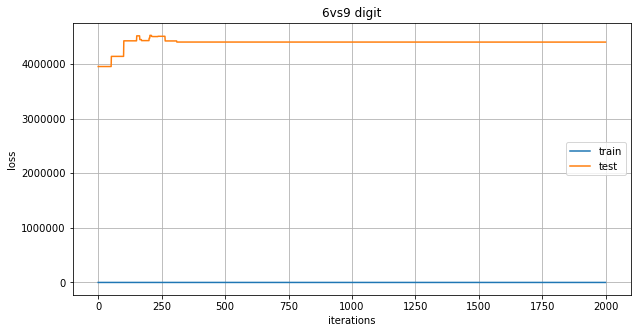

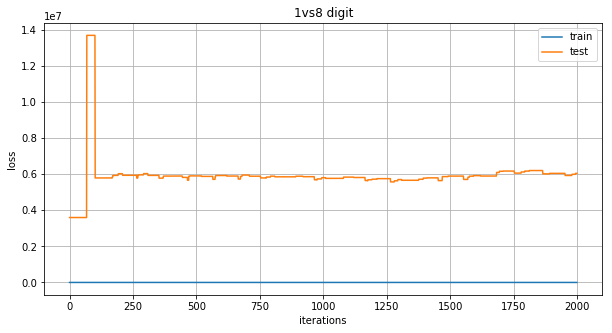

In [4]:
figure = plt.figure(121,figsize=(10,5))
plt.title('6vs9 digit')
plot_tr, = plt.plot(train_loss_histo_0,label='train')
plot_ts, = plt.plot(test_loss_histo_0,label='test')
plt.legend(handles=[plot_tr,plot_ts])
plt.ylabel('loss')
plt.xlabel('iterations')
plt.grid(True)

figure = plt.figure(122,figsize=(10,5))
plt.title('1vs8 digit')
plot_tr, = plt.plot(train_loss_histo_1,label='train')
plot_ts, = plt.plot(test_loss_histo_1,label='test')
plt.legend(handles=[plot_tr,plot_ts])
plt.ylabel('loss')
plt.xlabel('iterations')
plt.grid(True)

plt.show()

# Train vs Test.

In this 1vs1 classification test loss in train immediately goes to zero wile in test it either oscillate or also increases.
This happens when training on minibatches, loss on a batch can be reduced almost immediately but when having more data all at once
perceptron can still perfom also in test (see ROC 1 vs Multi).

In [5]:
clflin = Perceptron(hinge_loss,hinge_loss_grad)
train_scores_lin, test_scores_lin, roc_curves_lin, w_finals = USPS.usps_1vsMulti_class_train_and_test(trainx,trainy,testx,testy,clflin)


trainig, using 1 vs multi


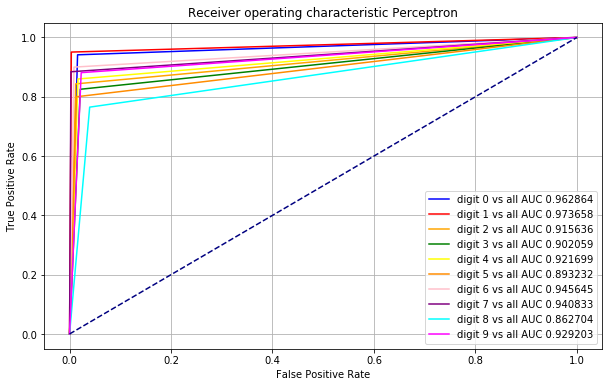

In [6]:
def plot_ROCS_multiclass(roc_curves_values,title='Receiver operating characteristic example'):
    labels = ['digit %d vs all AUC %f' % (i,roc_curves_values[i][2]) for i in range(len(roc_curves_values))]
    colors = ['blue','red','orange','green','yellow','darkorange','pink','purple','cyan','magenta']
    plot_ROCS(roc_curves_values,colors,labels,title=title)

def plot_ROCS(roc_curves_values,colors,labels,title='Receiver operating characteristic example'):
    plt.figure(0, figsize=(10, 6))
    plots = []
    for i in range(len(roc_curves_values)):
        fpr,tpr,roc_auc = roc_curves_values[i]
        plot, = plt.plot(fpr, tpr, color=colors[i], label=labels[i])
        plots += [plot]
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.legend(handles=plots)
    plt.grid(True)
    plt.title(title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_ROCS_multiclass(roc_curves_lin, title='Receiver operating characteristic Perceptron')
plt.show()

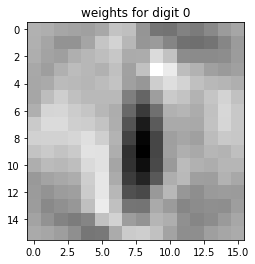

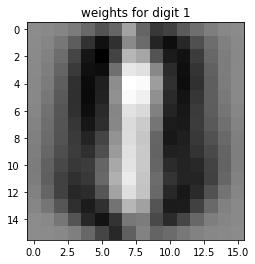

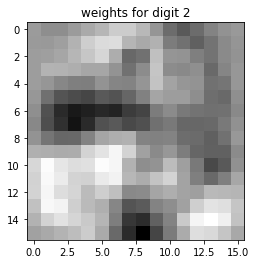

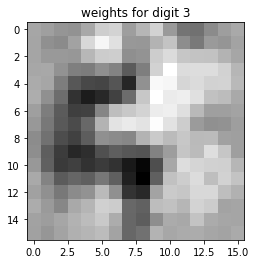

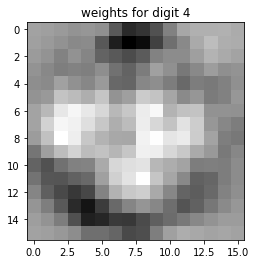

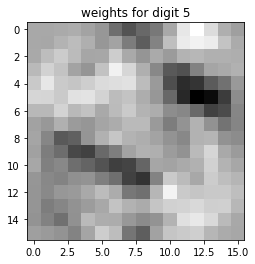

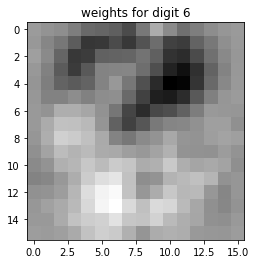

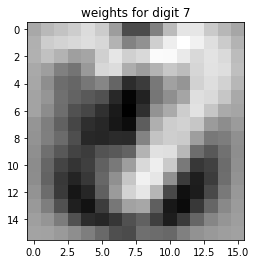

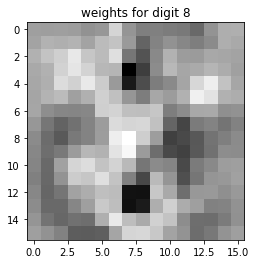

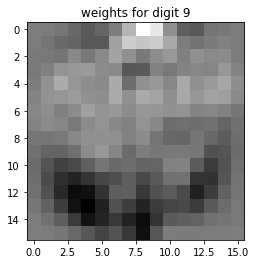

In [7]:
for i in range(10):
    plt.title('weights for digit %d' % i)
    USPS.show_usps(w_finals[i])
